In [1]:
install.packages("kknn")
install.packages("ggcorrplot")
install.packages("cowplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(ggcorrplot)
library(cowplot)
library(shiny)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

# Predicting The Occurrence of Exercised Induced-Angina by Analysis of Age and Maximum Heart Rate
Angelyca  P, Jay P, Elaine S 

# Introduction: 

### Background Information: 

Angina is categorized as a type of chest pain due to a reduced blood flow to the heart. Specific to this project, exercise induced angina is being analyzed and predicted. Exercise induced angina is a distinct class of angina, as the symptoms only occur when triggered by exercise. When the body is at rest, there is a lower demand of oxygen, allowing the heart to properly function despite the limiting amount of blood flow, with the absence of angina symptoms. Whereas, during exercise, the body will have an increased demand of oxygen, and thus blood flow. However, in this case, the heart is unable to function with the lack of oxygen, without experiencing chest pain sensations, or angina symptoms. Many studies have shown that increasing age is often accompanied with a greater risk of experiencing general angina. Studies have shown that increasing age is often accompanied with a greater risk of experiencing angina (chest pain). 

To conduct our data analysis, a number of different combinations of two predictors will be tested, where the best combination will be chosen and used as predictors for classifying the occurrence of exercise induced angina. A knn classification model will be created and tested for this type of data analysis. 


### Predictive Question: Will the individual experience exercise induced angina? 



### Wrangling and Cleaning Data 

In [4]:
# Downloading the raw dataset from the web and renaming columns.
url <- "https://raw.githubusercontent.com/elaines6/dsci-100-group-project/main/processed.cleveland.data"

heart_raw <- read_csv(url, col_names = c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"))

# Taking out the NA/? values of the raw dataset 
missing <- heart_raw == "?"
is.na(heart_raw) <- missing 

# Seeing if there are any NA/missing values from the dataset.
heart_raw[heart_raw == "?"] <- NA

heart_raw %>%
    map_df(~sum(is.na(.x)))


### FIX THIS HERE BITCH ###


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): major_vessels, thal
dbl (12): age, sex, chest_pain_type, resting_bp, chol, fasting_bs, rest_ecg,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,4,2,0


In [40]:
# Clean and tidy dataset 
heart_clean <- na.omit(heart_raw)|>
mutate(major_vessels = as.integer(major_vessels), thal = as.integer(thal))
h2("Figure 1: insert title")
heart_clean

Shiny tags cannot be represented in plain text (need html)

age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


In [8]:
# Checking if standardizing the data matters for plotting 
# There is no difference between plotting standardized or unstandardized data
unscaled_heart_data_to_check <- heart_clean |>
    select(max_rate, age, exercise_induced_angina) |>
    mutate(age = as.integer(age), max_rate = as.integer(max_rate))

# used ggcorrplot to summarize our process of testing variation of combinations and analyzing which combination is the best one

final_unscaled_heart_data <- heart_clean |>
    select(age, max_rate, exercise_induced_angina) |>
    mutate(age = as.integer(age), max_rate = as.integer(max_rate)) 


### Testing correlation between a combination of predictors

Shiny tags cannot be represented in plain text (need html)

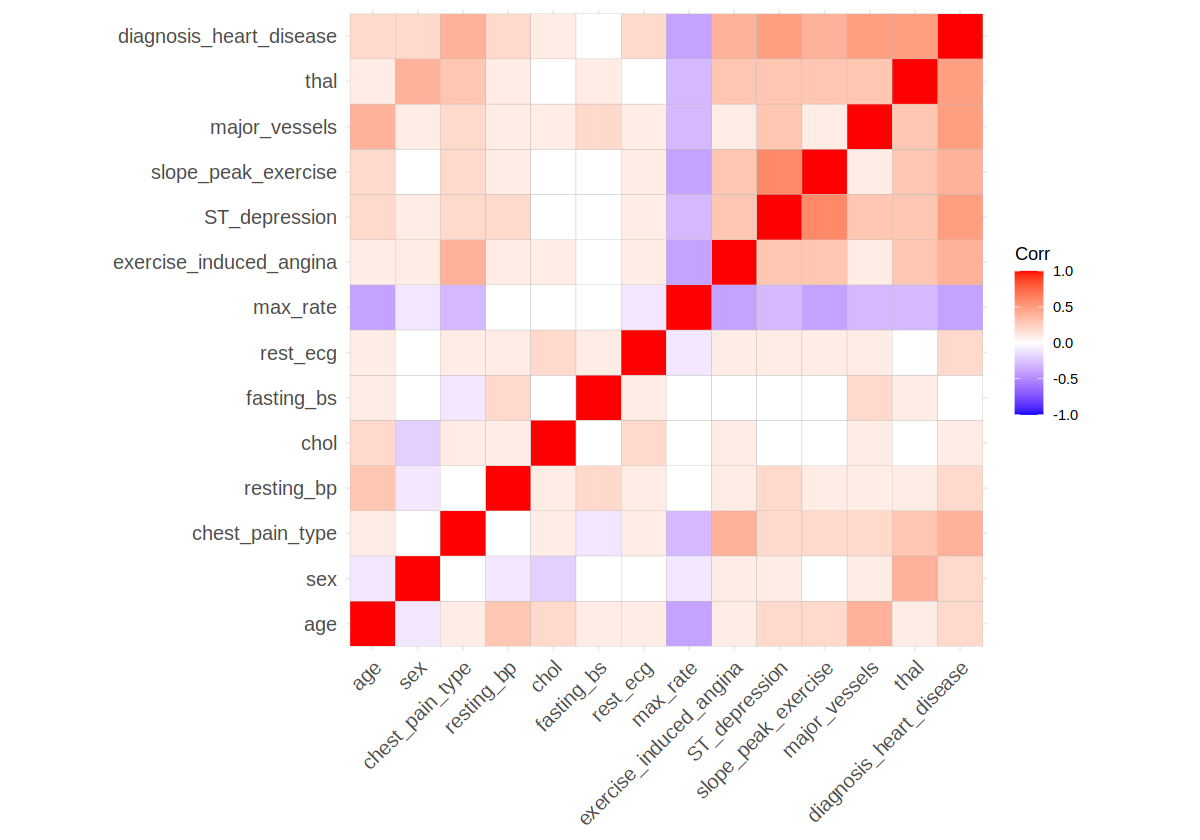

In [9]:
# used ggcorrplot to summarize our process of testing variation of combinations and analyzing which combination is the best one 
options(repr.plot.height = 7, repr.plot.width = 10)
corr <- round(cor(heart_clean), 1) 
h2("Figure 1. Correlation matrix of predictors")
ggcorrplot(corr)

# After analysis of the correlation matrix, we have decided to use the predictors of age and 
# heart_plot_four presents the best data to use for a classification question/model 

## EXPLANATION OF WHY WE PICKED PREDICTORS OF AGE AND MAX RATE (ANGELYCA) 

### Summary of data: computing averages

In [10]:
# Calculating the average values of the each columns.  
mean_of_columns <- heart_clean |>
    select(age:diagnosis_heart_disease) |>
  map_dfr(mean)

head(mean_of_columns)

age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.54209,0.6767677,3.158249,131.6936,247.3502,0.1447811,0.996633,149.5993,0.3265993,1.055556,1.602694,0.6767677,4.73064,0.9461279


### TALK ABOUT WHY WE USED STANDARDIZED DATA AND NOT UNSTANDARDIZED !!! (ANGELYCA)

In [11]:
# as_factor to make exercise_induced_angina the classifer
heart_clean <- heart_clean |>
    select(age, max_rate, exercise_induced_angina) |>
    mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
    mutate(exercise_induced_angina = fct_recode(exercise_induced_angina, "Yes" = "1", "No" = "0"))
heart_clean

age,max_rate,exercise_induced_angina
<dbl>,<dbl>,<fct>
63,150,No
67,108,Yes
67,129,Yes
⋮,⋮,⋮
68,141,No
57,115,Yes
57,174,No


## KNN Classification Model

In [20]:
# Scaling and centering all predictors/values of the dataset
heart_recipe <- recipe(exercise_induced_angina ~ ., data = heart_clean) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
    prep()

# The standardized dataset 
scaled_heart_rate <- bake(heart_recipe, heart_clean)
scaled_heart_rate

age,max_rate,exercise_induced_angina
<dbl>,<dbl>,<fct>
0.9346033,0.01746496,No
1.3766051,-1.81327350,Yes
1.3766051,-0.89790427,Yes
⋮,⋮,⋮
1.4871056,-0.3748361,No
0.2716005,-1.5081504,Yes
0.2716005,1.0636012,No


In [21]:
# Computing the total number of observations in the dataset. 
heart_clean |>
    group_by(exercise_induced_angina)|>
    summarize(count= n())

exercise_induced_angina,count
<fct>,<int>
No,200
Yes,97


In [23]:
# Standardized data plot 
heart_plot_testing <- scaled_heart_rate |>
    ggplot(aes(x = age, y = max_rate, color = as_factor(exercise_induced_angina)))+ 
    geom_point(alpha = 0.5) +
    labs(x = "Age (standardized)", 
         y = "Maximum Heart Rate (standardized)",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    ggtitle("Figure 2. Diagnosis of exercise induced angina with standardized max heart rate and age") +
    theme(text = element_text(size = 10))

In [24]:
# Unstandardized data plot 
heart_plot_four <- heart_clean |>
    ggplot(aes(x = age, y = max_rate, color = as_factor(exercise_induced_angina))) + 
    geom_point(alpha = 0.5) +
    labs(x = "Age", 
         y = "Maximum Heart Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    ggtitle("Figure 2. Diagnosis of exercise induced angina with max heart rate and age") + 
    theme(text = element_text(size = 10))

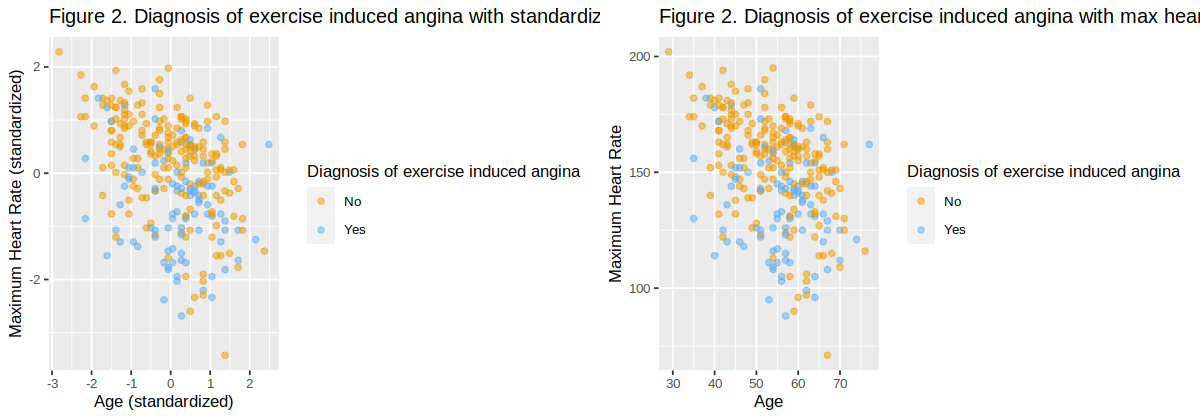

In [25]:
# Plotting standardized vs unstandardized data to visualize if there are any differences 
options(repr.plot.height = 3.5, repr.plot.width = 10)
plot_grid(heart_plot_testing, heart_plot_four)

In [28]:
# Splitting the data into a training and testing test 
set.seed(1234)
heart_split <- initial_split(heart_clean, prop = 0.75, strata = exercise_induced_angina)
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

In [29]:
# Getting the proportion of the induced_angina in the training set 
heart_proportions <- heart_train |>
                      group_by(exercise_induced_angina) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))

heart_proportions

exercise_induced_angina,n,percent
<fct>,<int>,<dbl>
No,150,67.56757
Yes,72,32.43243


In [30]:
# Creating a recipe for predicting the class of exericse induced angina based on the two predictors of age and max rate. 
heart_recipe <- recipe(exercise_induced_angina ~ age + max_rate, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [31]:
# Creating a classification model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

## Cross Validation of the Classification Model 

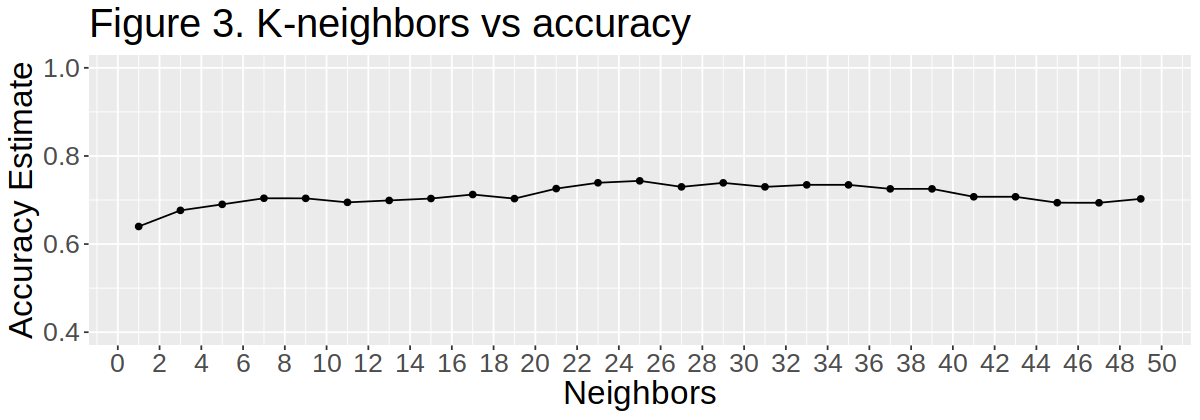

In [36]:
# Performing cross-validation on the training data 
set.seed(1234) 
heart_vfold <- vfold_cv(heart_train, v = 10, strata = exercise_induced_angina)

# Creating a data frame with k variable values that will be tested for accuracies 
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Computing all metrics of training data with specified k values above  
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

# Filtered for only the accuracy metric  
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Use a scatterplot to visualize the accuracy based on the knn neighbor values 
# Choose the best knn value based on the highest accuracy value   
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     ggtitle("Figure 3. K-neighbors vs accuracy") + 
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 50, by = 2)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k


# CHANGE BEST K VALUE!!! 

In [37]:
# Creating a new classification model with computed ideal k value 
final_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 42) |>
       set_engine("kknn") |>
       set_mode("classification")

# Fitting the training data to the ideal k value classification model 
final_heart_fit <- workflow() |>
             add_recipe(heart_recipe) |>
             add_model(final_heart_spec) |>
            fit(data = heart_train)
final_heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(42,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2612613
Best kernel: rectangular
Best k: 42

In [38]:
# Predicting the class label of the testing data in the fitted workflow 
heart_predictions <- predict(final_heart_fit, heart_test) |>
                        bind_cols(heart_test)
heart_predictions
 
# Extracting the metrics aka the accuracy of the model 
heart_metrics <- heart_predictions |> metrics(truth = exercise_induced_angina, estimate = .pred_class)

# Extracting the confusion matrix table 
heart_conf_mat <- heart_predictions |>
                        conf_mat(truth = exercise_induced_angina, estimate = .pred_class) 
heart_metrics
heart_conf_mat

# Top left value = True negative, Top right value = False negative 
# Bottom left value = False positive, Bottom right value = True positive 

.pred_class,age,max_rate,exercise_induced_angina
<fct>,<dbl>,<dbl>,<fct>
No,63,150,No
No,62,160,No
Yes,56,142,Yes
⋮,⋮,⋮,⋮
No,56,169,No
No,63,136,Yes
Yes,57,115,Yes


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7866667
kap,binary,0.4782609


          Truth
Prediction No Yes
       No  46  12
       Yes  4  13

# Discussion 

#### Summarize your findings here:

The accuracy for our classification model is computed to be 78.67% as shown above in the metrics table. This accuracy metric indicates that our classification model will accurately predict the occurrence of exercise induced angina, given an unknown observation, 78.67% of the time. As for the confusion matrix table, there are some important findings to note here. 

Specific to this data analysis of exercise induced angina, the false negative prediction is the most serious. Specific to this case study, a false negative prediction occurs when an individual with exercise induced angina, is predicted to not have exercise induced angina. The false negative prediction for this data set is computed to occur 18 times for every 76 predictions. As for the others (false negative, false positive, true negative), they hold a less significant impact on the predictions. 






#### What impact could such findings have? 
Such findings of this data analysis would be able to predict whether or not individuals will experience exercise induced angina, based on their maximum heart rate and age. 


#### What future questions could this lead to?
What other predictors could be used to accurately predict whether an individual will exercise induced angina ? Can the occurrence of exercise induced angina be a predictor of other underlying cardiac health issues (if an individual experiences exercise induced angina, are they at a higher risk for cardiac arrest, stroke, and other complications ?)





### References: (cite these at the end) 

https://archive.ics.uci.edu/dataset/45/heart+disease


https://www.ahajournals.org/doi/10.1161/01.CIR.0000086898.96021.B9#:~:text=Pain%20in%20the%20left%20chest,more%20frequent%20with%20advancing%20age.
